# Anomaly Detection and Recommender Systems

# Introduction

First, the anomaly detection algorithm will be implemented and applied to detect failing servers on a network. Next, collaborative filtering will be used to build a recommender system for movies.

# Anomaly Detection

An anomaly detection algorithm will be implemented to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While the servers were operating, $m = 307$ examples of how they were behaving were collected, and thus having an unlabeled dataset $\left\{x^{(1)},\dots,x^{(m)}\right\}$. It is suspected that the vast majority of these examples are "normal" (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

A Gaussian model will be used to detect anomalous examples in the dataset. First, a 2D dataset will allow to visualize what the algorithm is doing. On that dataset a Gaussian distribution will be fitted in order to find values that have very low probability and hence can be considered anomalies. After that, the anomaly detection algorithm will be applied to a larger dataset with many dimensions.

__header__
__version__
__globals__
X
Xval
yval

Visualizing example dataset for outlier detection.


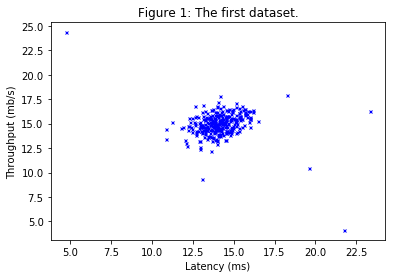

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load dataset.
data1 = loadmat('ex8data1.mat')

for key in data1:
    print(key)

X = data1["X"]
Xval = data1["Xval"]
yval = data1["yval"].flatten() # shape must be (307,) to use it in "selectThreshold".

print('\nVisualizing example dataset for outlier detection.')
# Visualize the example dataset.
plt.plot(X[:, 0], X[:, 1], 'bx', markersize=3)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Figure 1: The first dataset.')
plt.show()

## Gaussian Distribution

To perform anomaly detection, first a model will be fitted to the data’s distribution. Given a training set $\left\{x^{(1)},\dots,x^{(m)}\right\} \left(\text{ where } x^{(i)} \in \mathbb{R}^n \right)$, the Gaussian distribution for each of the features $x_i$ have to be estimated. For each feature $i = 1 \dots n$, the parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i-th$ dimension $\left\{x_i^{(1)},\dots,x_i^{(m)}\right\}$ will be found. (the $i-th$ dimension of each example). The Gaussian distribution is given by:

$$p\left(x;\mu,\sigma^2\right)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{\left(z-\mu\right)^2}{2\sigma^2}},$$

where $\mu$ is the mean and $\sigma^2$ controls the variance.

## Estimating Parameters for a Gaussian

The parameters $\left(\mu_i, \sigma_i^2\right)$ of the $i-th$ feature can be estimated by using the following equations:

$$\mu_i=\frac{1}{m}\sum_{j=1}^{m}x_i^{(j)} \text{ and } \sigma_i^2=\frac{1}{m}\sum_{j=1}^{m}\left(x_i^{(j)}-\mu_i\right)^2$$

The code in `estimateGaussian` function will take as input the data matrix $X$ and output an $n$-dimension vector
`mu` that holds the mean of all the $n$ features and another $n$-dimension vector `sigma2` that holds the variances of all the features. This can implemented using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient).

The contours of the fitted Gaussian distribution are visualized in Figure 2. From the plot, it can be seen that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

Visualizing Gaussian fit.


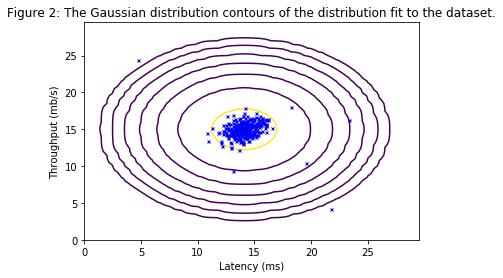

In [2]:
import scipy.linalg as linalg

# Create a function to compute the parameters of a Gaussian distribution.
def estimateGaussian(X):
    """
    Estimates the parameters (mean, variance) of a
    Gaussian distribution using the data in X.
    Args:
        X     : array(# of training examples m, # of features n)
    Returns:
        mu    : array(# of features n, 1)
        sigma2: array(# of features n, 1)
    """
    # Get useful variables.
    m, n = X.shape
    
    # Init mu and sigma2.
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    
    mu = np.mean(X.T, axis=1)
    mu = mu.reshape(mu.shape[0], -1)
    sigma2 = np.var(X.T, axis=1)
    sigma2 = sigma2.reshape(sigma2.shape[0], -1)

    return mu, sigma2

# Create a function to compute the probability.
def multivariateGaussian(X, mu, Sigma2):
    """
    Computes the probability density function of the examples X
    under the multivariate gaussian distribution with parameters
    mu and sigma2. If Sigma2 is a matrix, it is treated as the
    covariance matrix. If Sigma2 is a vector, it is treated as the
    sigma^2 values of the variances in each dimension (a diagonal
    covariance matrix).
    Args:
        X     : array(# of training examples m, # of features n)
        mu    : array(# of features n, 1)
        Sigma2: array(# of features n, # of features n)
    Returns:
        p     : array(# of training examples m,)
    """
    k = len(mu)

    if (Sigma2.shape[0] == 1) or (sigma2.shape[1] == 1):
        Sigma2 = linalg.diagsvd(Sigma2.flatten(),
                                len(Sigma2.flatten()),
                                len(Sigma2.flatten()))
        X = X - mu.T
        p = np.dot(np.power(2 * np.pi, - k / 2.0),
                   np.power(np.linalg.det(Sigma2), -0.5)) * \
        np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(Sigma2)) * X, axis=1))

    return p

# Create a function to visualize the dataset and its estimated distribution.
def visualizeFit(X, mu, sigma2):
    """
    Visualizes the dataset and its estimated distribution.
    This visualization shows the probability density function
    of the Gaussian distribution. Each example has a location
    (x1, x2) that depends on its feature values.
    Args:
        X     : array(# of training examples m, # of features n)
        mu    : array(# of features n, 1)
        sigma2: array(# of features n, 1)
    """
    X1, X2 = np.meshgrid(np.arange(0, 30, 0.5), np.arange(0, 30, 0.5))
    Z = multivariateGaussian(np.column_stack((X1.reshape(X1.size),
                                              X2.reshape(X2.size))),
                             mu, sigma2)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1],'bx', markersize=3)

    # Do not plot if there are infinities.
    if (np.sum(np.isinf(Z)) == 0):
        plt.contour(X1, X2, Z, np.power(10,(np.arange(-20, 0.1, 3)).T))


print('Visualizing Gaussian fit.')

# Estimate mu and sigma2.
mu, sigma2 = estimateGaussian(X)

# Return the density of the multivariate normal at each data point (row) of X.
p = multivariateGaussian(X, mu, sigma2)

# Visualize the fit.
visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Figure 2: The Gaussian distribution contours \
of the distribution fit to the dataset.')
plt.show()

## Selecting the Threshold, $\varepsilon$

Now that the Gaussian parameters have been estimated, it can be investigated which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in the dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. An algorithm will be implemented to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

The code in `selectThreshold` uses a cross validation set $\left\{\left(x_{cv}^{\left(1\right)}, y_{cv}^{\left(1\right)}\right),\dots, \left(x_{cv}^{\left(m_{cv}\right)}, y_{cv}^{\left(m_{cv}\right)} \right) \right\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, $p\left(x_{cv}^{\left(i\right)}\right)$ will be computed. The vector of all of these probabilities $p\left(x_{cv}^{\left(1\right)}\right), \dots, p\left(x_{cv}^{\left(m_{cv}\right)} \right)$ is passed to `selectThreshold` in the vector `pval`. The corresponding labels $y_{cv}^{\left(1\right)},\dots,y_{cv}^{\left(m_{cv}\right)}$ is passed to the same function in the vector `yval`.

The function `selectThreshold` returns two values; the first is the selected threshold $\varepsilon$. If an example $x$ has a low probability $p(x) < \varepsilon$, then it is considered to be an anomaly. The function also returns the $F_1$ score, which tells how well it is doing on finding the ground truth anomalies given a certain threshold. For many different values of $\varepsilon$, the resulting $F_1$ score will be computed by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision $(prec)$ and recall $(rec)$:

$$ F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}, $$

Precision and recall are computed by:

$$ prec = \frac{tp}{tp + fp} $$

$$ rec = \frac{tp}{tp + fn}, $$

where
* $tp$ is the number of true positives: the ground truth label says it’s an anomaly and the algorithm correctly classified it as an anomaly.
* $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but the algorithm incorrectly classified it as an anomaly.
* $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but the algorithm incorrectly classified it as not being anomalous.

In the code `selectThreshold`, a loop will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. The computation of the $F_1$ score can be implemented using a for-loop over all the cross validation examples $\left(\text{to compute the values }tp, fp, fn\right)$. The
value for $\varepsilon$ should be about $8.99e-05$. Figure 3 plots the anomalies in a circle.

Best epsilon found using cross-validation: 8.990852779269495e-05
Best F1 on Cross Validation Set:  0.8750000000000001
(A value epsilon of about 8.99e-05 is expected.)


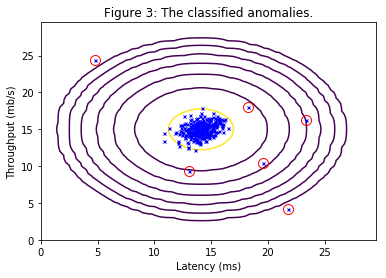

In [3]:
# Create a function to find the best threshold epsilon.
def selectThreshold(yval, pval):
    """
    Finds the best threshold to use for selecting outliers
    based on the results from a validation set (pval) and
    the ground truth (yval).
    Args:
        yval       : array(# of cv examples,)
        pval       : array(# of cv examples,)
    Returns:
        bestEpsilon: float
        bestF1     : float
    """
    # Init values.
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    stepsize = (max(pval) - min(pval)) / 1000
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        # Use predictions to get a binary vector of
        # 0's and 1's of the outlier predictions.
        predictions = pval < epsilon
        tp = sum(((yval == 1) & (predictions == 1)))
        fp = sum((yval == 0) & (predictions == 1))
        fn = sum((yval == 1) & (predictions == 0))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = 2 * prec * rec / (prec + rec)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1


pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: {}'.format(epsilon))
print('Best F1 on Cross Validation Set:  {}'.format(F1))
print('(A value epsilon of about 8.99e-05 is expected.)')

# Find the outliers in the training set and plot them.
outliers = p < epsilon

# Draw a red circle around those outliers.
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', markersize=10, fillstyle='none')
visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Figure 3: The classified anomalies.')
plt.show()

## High Dimensional Dataset

The anomaly detection algorithm will be applied now on a more realistic and much harder dataset. In this dataset, each example is described by $11$ features, capturing many more properties of the compute servers.

The code will estimate the Gaussian parameters $\left(\mu_i \text{ and } \sigma_i^2\right)$, evaluate the probabilities for both the training data $X$ from which the Gaussian parameters were estimated, and do so for the the cross-validation set $Xval$. Finally, the `selectThreshold` will be used to find the best threshold $\varepsilon$. A value epsilon of about $1.38e-18$, and $117$ anomalies shall be found.

In [4]:
# Load the second dataset.
data2 = loadmat('ex8data2.mat')
X = data2["X"]
Xval = data2["Xval"]
yval = data2["yval"].flatten()

# Apply the same steps to the larger dataset.
mu, sigma2 = estimateGaussian(X)

# Training set. 
p = multivariateGaussian(X, mu, sigma2)

# Cross-validation set.
pval = multivariateGaussian(Xval, mu, sigma2)

# Find the best threshold.
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: {}'.format(epsilon))
print('Best F1 on Cross Validation Set: {}'.format(F1))
print('# Outliers found: {}'.format(sum(p < epsilon)))

Best epsilon found using cross-validation: 1.377228890761358e-18
Best F1 on Cross Validation Set: 0.6153846153846154
# Outliers found: 117


# Recommender Systems

The collaborative filtering learning algorithm will be implemented and applied to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

The code in the function `cofiCostFunc` computes the collaborative fitlering objective function and gradient. The function `minimize` will be used to learn the parameters for collaborative filtering.

## Movie Ratings Dataset

The variable $Y$ (a `num_movies x num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The variable $R$ is a binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow to recommend the movies with the highest predicted ratings to the user.

To understand the matrix $Y$, the average movie rating will be computed for the first movie (Toy Story) and output the average rating to the screen.

The matrices, $X$ and $Theta$ will be also used:

$$X = \begin{bmatrix}
    -\left(x^{(1)}\right)^T-\\
    -\left(x^{(2)}\right)^T-\\
    \vdots\\
    -\left(x^{(n_m)}\right)^T-\end{bmatrix}, \quad
    Theta = \begin{bmatrix}
    -\left(\theta^{(1)}\right)^T-\\
    -\left(\theta^{(2)}\right)^T-\\
    \vdots\\
    -\left(\theta^{(n_u)}\right)^T-\end{bmatrix}.$$
    
The $i-th$ row of $X$ corresponds to the feature vector $x^{(i)}$ for the $i-th$ movie, and the $j-th$ row of $Theta$ corresponds to one parameter vector $\theta^{(j)}$, for the $j-th$ user. Both $x^{(i)}$ and $\theta^{(j)}$ are $n$-dimensional vectors. $n = 100$ will be used, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$. Correspondingly, $X$ is a $n_m \times 100$ matrix and $Theta$ is a $n_u \times 100$ matrix.

## Collaborative Filtering Learning Algorithm

First the cost function (without regularization) will be implemented.

The collaborative filtering algorithm in the setting of movie recommendations considers a set of $n$-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)} \text{ and } \theta^{(1)}, \dots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left(\theta^{(j)}\right)^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error) will be learnt.

Note that the parameters to the function `minimize` are $X$ and $Theta$.

### Collaborative Filtering Cost Function

The collaborative filtering cost function (without regularization) is given by

$$ J\left(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)} \right) = \frac{1}{2} \sum_{(i, j):r(i, j)=1} \left(\left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2.$$

The `cofiCostFunc` function will return this cost in the variable $J$. Note that the cost should be accumulated for user $j$ and movie $i$ only if $R(i,j) = 1$. An output cost of $22.22$ is expected.

**Implementation Note:** A vectorized implementation to compute $J$ is strongly recommended, since it will later be called many times by the optimization package `minimize`. To come up with a vectorized implementation, the following tip is helpful: The $R$ matrix can be used to set selected entries to 0. For example, $R * M$ will do an element-wise multiplication between $M$ and $R$; since $R$ only has elements with values either 0 or 1, this has the effect of setting the elements of $M$ to 0 only when the corresponding value in $R$ is 0. Hence, `np.sum(error * R)` is the sum of all the elements of $M$ for which the corresponding element in $R$ equals 1.

### Collaborative Filtering Gradient

Next the gradient will be implemented in `cofiCostFunc`. The code will return the variables `X_grad` and `Theta_grad`. Note that `X_grad` is a matrix of the same size as $X$ and similarly, `Theta_grad` is a matrix of the same size as $Theta$. The gradients of the cost function is given by:

$$\frac{\partial{J}}{\partial{x_k^{(i)}}}=\sum_{j:r(i,j)=1} \left(\left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)\theta_k^{(j)}$$

$$\frac{\partial{J}}{\partial{\theta_k^{(j)}}}=\sum_{j:r(i,j)=1} \left(\left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)x_k^{(i)}$$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. A gradient check (`checkCostFunction`) will be applied to numerically check the implementation of the gradients. If the implementation is correct, then the analytical and numerical gradients match up closely.

**Implementation Note:** A vectorized implementation is recommended. The gradient can be implemented with a for-loop over movies (for computing $\frac{\partial{J}}{\partial{x_k^{(i)}}}$) and a for-loop over users (for computing $\frac{\partial{J}}{\partial{\theta_k^{(j)}}}$). To perform the vectorization, it must be found a way to compute all the derivatives associated with $x_1^{(i)}, x_2^{(i)},\dots, x_n^{(i)}$ (i.e., the derivative terms associated with the feature vector $x^{(i)}$) at the same time. The derivatives for the feature vector of the $i-th$ movie can be defined as:

$$\left(X_{grad}\left(i,:\right)\right)^T=\begin{bmatrix}
    \frac{\partial{J}}{\partial{x_1^{(i)}}}\\
    \frac{\partial{J}}{\partial{x_2^{(i)}}}\\
    \vdots\\
    \frac{\partial{J}}{\partial{x_n^{(i)}}}\end{bmatrix}=
    \sum_{j:r(i,j)=1} \left(\left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)\theta^{(j)}$$
    
As previously noted, an element-wise multiplication with $R$ is the trick. A similar method can be used to vectorize the derivatives with respect to $\theta^{(j)}$ as well.

Loading movie ratings dataset.
Average rating for movie 1 (Toy Story): 3.88/5


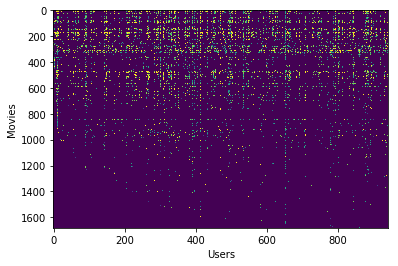

Cost at loaded parameters: 22.22
(this value should be about 22.22)


In [5]:
print('Loading movie ratings dataset.')

# Load data.
data3 = loadmat('ex8_movies.mat')

# Y is a 1682x943 matrix, containing ratings (1-5)
# of 1682 movies on 943 users.
Y = data3["Y"]
# R is a 1682x943 matrix, where R(i,j) = 1 if and only if
# user j gave a rating to movie i.
R = data3["R"]

# From the matrix, statistics like average rating can be computed.
print('Average rating for movie 1 (Toy Story): {0:.2f}/5'.\
      format(np.mean(Y[0, R[0, :]==1])))

# Visualize the ratings matrix by plotting it with imshow.
plt.imshow(Y, aspect='auto') 
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show()

# Load pre-trained weights (X, Theta, num_users, num_movies, num_features).
data4 = loadmat('ex8_movieParams.mat')
X = data4["X"]
Theta = data4["Theta"]

# Reduce the data set size so that this runs faster.
num_users = 4 
num_movies = 5 
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

# Create a function to compute the cost J and grad.
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_coef):
    """
    Returns the cost and gradient for
    the collaborative filtering problem.
    Args:
        params      : array(num_movies x num_features + num_users x num_features,)
        Y           : array(num_movies, num_users)
        R           : array(num_movies, num_users)
        num_users   : int
        num_movies  : int
        num_features: int
        lambda_coef : float
    Returns:
        J           : float
        grad        : array(num_movies x num_features + num_users x num_features,)
    """
    # Unfold params back into the parameters X and Theta.
    X = np.reshape(params[:num_movies * num_features], (num_movies, num_features))
    Theta = np.reshape(params[num_movies * num_features:], (num_users, num_features))
    
    # Init values.
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # Compute squared error.
    error = np.square(np.dot(X, Theta.T) - Y)
    
    # Compute regularization term.
    reg_term = (lambda_coef / 2) * (np.sum(np.square(Theta)) + np.sum(np.square(X)))

    # Compute cost function but sum only if R(i,j)=1; vectorized solution.
    J = (1 / 2) * np.sum(error * R) + reg_term
    
    # Compute the gradients.
    X_grad = np.dot((np.dot(X, Theta.T) - Y) * R, Theta) + lambda_coef * X
    Theta_grad = np.dot(((np.dot(X, Theta.T) - Y) * R).T, X) + lambda_coef * Theta
    
    grad = np.concatenate((X_grad.reshape(X_grad.size),
                           Theta_grad.reshape(Theta_grad.size)))
    
    return J, grad


# Create a list of my X and Theta.
lst_params = [X, Theta]

# Unroll parameters and then merge/concatenate.
unrolled_params = [lst_params[i].ravel() for i,_ in enumerate(lst_params)]
params = np.concatenate(unrolled_params)

# Evaluate cost function.
J, _ = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)
           
print('Cost at loaded parameters: {:0.2f}'.format(J))
print('(this value should be about 22.22)')

### Regularized Cost Function

The cost function for collaborative filtering with regularization is given by:

$$ J\left(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)} \right) = \frac{1}{2} \sum_{(i, j):r(i, j)=1} \left(\left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left(\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n\left(\theta_k^{(j)}\right)^2\right) + \left(\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^n\left(x_k^{(i)}\right)^2\right).$$

### Regularized Gradient

The gradients for the regularized cost function is given by:

$$\frac{\partial{J}}{\partial{x_k^{(i)}}}=\sum_{j:r(i,j)=1} \left(\left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)\theta_k^{(j)} + \lambda x_k^{(i)}$$

$$\frac{\partial{J}}{\partial{\theta_k^{(j)}}}=\sum_{j:r(i,j)=1} \left(\left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)x_k^{(i)} + \lambda \theta_k^{(j)}.$$

In [6]:
# Create a function to compute numerical gradient.
def computeNumericalGradient(J, theta):
    """
    Computes the numerical gradient of the function J
    around theta using "finite differences" and gives
    a numerical estimate of the gradient.
    Notes: The following code implements numerical
           gradient checking, and returns the numerical
           gradient. It sets numgrad(i) to (a numerical 
           approximation of) the partial derivative of J
           with respect to the i-th input argument,
           evaluated at theta. (i.e., numgrad(i) should
           be the (approximately) the partial derivative
           of J with respect to theta(i).)
    Args:
        J      : function
        theta  : array(num_movies x num_features + num_users x num_features,)
    Returns:
        numgrad: array(num_movies x num_features + num_users x num_features,)
    """
    # Initialize parameters.
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4

    for p in range(theta.size):
        # Set the perturbation vector.
        perturb.reshape(perturb.size)[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute the Numerical Gradient.
        numgrad.reshape(numgrad.size)[p] = (loss2 - loss1) / (2 * e)
        perturb.reshape(perturb.size)[p] = 0
    
    return numgrad

# Create a function to check the cost function and gradients.
def checkCostFunction(lambda_coef):
    """
    Creates a collaborative filering problem 
    to check the cost function and gradients.
    It will output the analytical gradients
    and the numerical gradients computed using
    computeNumericalGradient. These two gradient 
    computations should result in very similar values.
    Args:
        lambda_coef : float
    """
    # Create small problem.
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)
    
    # Zap out most entries.
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking.
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    # Create short hand for cost function.
    def costFunc(p):
        return cofiCostFunc(p, Y, R, num_users, num_movies,
                            num_features, lambda_coef)

    params = np.concatenate((X.reshape(X.size), Theta.reshape(Theta.size)))
    numgrad = computeNumericalGradient(costFunc, params)
    J, grad = cofiCostFunc(params, Y, R, num_users, num_movies,
                           num_features, lambda_coef)
    
    # Visually examine the two gradient computations.
    for numerical, analytical in zip(numgrad, grad):
        print('Numerical Gradient: {0:10f}, Analytical Gradient {1:10f}'.\
              format(numerical, analytical))
    print('\nThe above two columns should be very similar.\n')
        
    # Evaluate the norm of the difference between two solutions.
    diff = np.linalg.norm(numgrad-grad) / np.linalg.norm(numgrad+grad)

    print('If the backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). \n' \
             '\nRelative Difference: {:.10E}'.format(diff))

    
print('Checking Gradients (without regularization)...\n')
# Check gradients by running checkCostFunction.
checkCostFunction(0)

Checking Gradients (without regularization)...

Numerical Gradient:   0.686844, Analytical Gradient   0.686844
Numerical Gradient:  -1.085872, Analytical Gradient  -1.085872
Numerical Gradient:   0.124596, Analytical Gradient   0.124596
Numerical Gradient:   4.824024, Analytical Gradient   4.824024
Numerical Gradient:   0.814955, Analytical Gradient   0.814955
Numerical Gradient:   3.834319, Analytical Gradient   3.834319
Numerical Gradient:  -0.141878, Analytical Gradient  -0.141878
Numerical Gradient:  -4.375483, Analytical Gradient  -4.375483
Numerical Gradient:  -0.663061, Analytical Gradient  -0.663061
Numerical Gradient:   0.995812, Analytical Gradient   0.995812
Numerical Gradient:  -7.859670, Analytical Gradient  -7.859670
Numerical Gradient:  -0.223696, Analytical Gradient  -0.223696
Numerical Gradient:   2.218259, Analytical Gradient   2.218259
Numerical Gradient: -12.149382, Analytical Gradient -12.149382
Numerical Gradient:  -5.047708, Analytical Gradient  -5.047708
Numeric

In [7]:
# Evaluate cost function.
J, _ = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda_coef = 1.5): {:0.2f}'\
         '\n(this value should be 31.34)\n'.format(J))

print('Checking Gradients (with regularization)... \n')

# Check gradients by running checkCostFunction.
checkCostFunction(1.5)

Cost at loaded parameters (lambda_coef = 1.5): 31.34
(this value should be 31.34)

Checking Gradients (with regularization)... 

Numerical Gradient:  -7.075429, Analytical Gradient  -7.075429
Numerical Gradient:  10.192719, Analytical Gradient  10.192719
Numerical Gradient:   7.315690, Analytical Gradient   7.315690
Numerical Gradient:   2.580425, Analytical Gradient   2.580425
Numerical Gradient:  -1.550883, Analytical Gradient  -1.550883
Numerical Gradient:   0.798064, Analytical Gradient   0.798064
Numerical Gradient:   0.300576, Analytical Gradient   0.300576
Numerical Gradient:   2.484021, Analytical Gradient   2.484021
Numerical Gradient:  -1.323129, Analytical Gradient  -1.323129
Numerical Gradient: -13.365154, Analytical Gradient -13.365154
Numerical Gradient:  -0.746613, Analytical Gradient  -0.746613
Numerical Gradient:  -8.361428, Analytical Gradient  -8.361428
Numerical Gradient:   1.965681, Analytical Gradient   1.965681
Numerical Gradient:  -4.477805, Analytical Gradient 

## Learning Movie Recommendations

Now the algorithm can be trained to make movie recommendations. First, an example of movie preferences will be entered, so that later when the algorithm runs, the movie recommendations can be computed based on the preferences. The list of all movies and their number in the dataset can be found listed in the file `movie_idx.txt`.

### Recommendations

After the additional ratings have been added to the dataset, the collaborative filtering model will be trained. This will learn the parameters $X$ and $Theta$. To predict the rating of movie $i$ for user $j$, the $\left(\theta^{(j)}\right)^T x^{(i)}$ need to be computed. Then, the ratings are computed for all the movies and users and the movies that are recommended are displayed, according to ratings that were entered earlier.

In [8]:
# Create a function to load movies.
def loadMovieList():
    """
    Reads the fixed movie list in movie_idx.txt
    and returns a cell array of the words in movieList.
    Returns:
        movieList: list
    """
    # Read the fixed movieulary list.
    with open('movie_ids.txt', encoding = "ISO-8859-1") as f:
        movieList = []
        for line in f:
            movieName = line.split()[1:]
            movieList.append(" ".join(movieName))

    return movieList

movieList = loadMovieList()

# Initialize ratings.
my_ratings = np.zeros((1682, 1))

# Check the file movie_idx.txt for id of each movie in the dataset.
# For example, Toy Story (1995) has ID 0, so to rate it "4", set:
my_ratings[0] = 4

# Or suppose did not enjoy The Mask (1994), so set:
my_ratings[71] = 1

# Select a few movies and rate them:
my_ratings[8] = 3
my_ratings[12]= 3
my_ratings[32]= 2
my_ratings[44] = 5
my_ratings[60] = 5
my_ratings[63] = 4
my_ratings[67] = 3
my_ratings[85] = 5
my_ratings[117] = 1
my_ratings[153] = 4
my_ratings[155] = 5
my_ratings[164] = 5
my_ratings[174] = 4
my_ratings[178] = 5
my_ratings[193] = 4
my_ratings[354] = 2
my_ratings[442] = 4
my_ratings[478] = 5
my_ratings[514] = 5
my_ratings[606] = 5
my_ratings[633] = 5
my_ratings[639] = 5
my_ratings[649] = 5
my_ratings[954] = 5
my_ratings[1422] = 3

print('User ratings:\n')
for i, rating in enumerate(my_ratings):
    if rating > 0: 
        print('Rated {} for {}'.format(rating[0], movieList[i]))

User ratings:

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Dead Man Walking (1995)
Rated 3.0 for Mighty Aphrodite (1995)
Rated 2.0 for Desperado (1995)
Rated 5.0 for Eat Drink Man Woman (1994)
Rated 5.0 for Three Colors: White (1994)
Rated 4.0 for Shawshank Redemption, The (1994)
Rated 3.0 for Crow, The (1994)
Rated 1.0 for Mask, The (1994)
Rated 5.0 for Remains of the Day, The (1993)
Rated 1.0 for Twister (1996)
Rated 4.0 for Monty Python's Life of Brian (1979)
Rated 5.0 for Reservoir Dogs (1992)
Rated 5.0 for Jean de Florette (1986)
Rated 4.0 for Brazil (1985)
Rated 5.0 for Clockwork Orange, A (1971)
Rated 4.0 for Sting, The (1973)
Rated 2.0 for Sphere (1998)
Rated 4.0 for Birds, The (1963)
Rated 5.0 for Vertigo (1958)
Rated 5.0 for Boot, Das (1981)
Rated 5.0 for Rebecca (1940)
Rated 5.0 for Microcosmos: Le peuple de l'herbe (1996)
Rated 5.0 for Cook the Thief His Wife & Her Lover, The (1989)
Rated 5.0 for Seventh Seal, The (Sjunde inseglet, Det) (1957)
Rated 5.0 for Before Sunrise 

### Learning Movie Ratings

Now, the collaborative filtering model will be trained on a movie rating dataset of 1682 movies and 943 users.

In [9]:
from scipy.optimize import minimize

print('Training collaborative filtering...')

# Load data.
Y = data3["Y"] # array(1682, 943)
R = data3["R"] # array(1682, 943)

# Add my ratings to the data matrix.
Y = np.column_stack((my_ratings, Y)) # array(1682, 944)
R = np.column_stack(((my_ratings != 0), R)) # array(1682, 944)

# Create a function to normalize ratings.
def normalizeRatings(Y, R):
    """
    Preprocesses data by subtracting mean rating for every
    movie (every row). Normalizes Y so that each movie has
    a rating of 0 on average, and returns the mean rating in Ymean.
    Args:
        Y    : array(num_movies, num_users)
        R    : array(num_movies, num_users)
    Returns:
        Ynorm: array(num_movies, num_users)
        Ymean: array(num_movies, 1)
    """
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = R[i, :] == 1
        # Compute the mean only of the rated movies.
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean

# Normalize ratings.
[Ynorm, Ymean] = normalizeRatings(Y, R)

# Get useful values.
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set initial parameters (Theta, X).
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate((X.reshape(X.size),
                                     Theta.reshape(Theta.size)))

# Set options.
options = {'maxiter': 100, 'disp': True}

# Set regularization.
lambda_coef = 10

# Create short hand for cost function.
def costFunc(initial_parameters):
    return cofiCostFunc(initial_parameters, Y, R, num_users,
                        num_movies, num_features, lambda_coef)

# Optimize.
results = minimize(costFunc, x0=initial_parameters,
                   options=options, method='CG', jac=True)
theta = results.x

# Unfold results back into the parameters X and Theta.
X = np.reshape(theta[:num_movies * num_features], (num_movies, num_features))
Theta = np.reshape(theta[num_movies * num_features:], (num_users, num_features))

print('\nRecommender system learning completed!')

Training collaborative filtering...
         Current function value: 72032.875579
         Iterations: 100
         Function evaluations: 156
         Gradient evaluations: 156

Recommender system learning completed!


### Recommendation for me

After training the model, recommendations can be generated by computing the predictions matrix.

In [10]:
p = np.dot(X, Theta.T)
# Get first column (my predictions) and add Ymean.
my_predictions = p[:, 0] + Ymean.flatten()

movieList = loadMovieList()

# Reverse sort by index.
ix = my_predictions.argsort()[::-1]

print('Top 10 recommendations for me:\n')
for i in range(10):
    j = ix[i]
    print('Predicting rating {:0.2f} for movie {}'.\
          format(my_predictions[j], movieList[j]))

print('\n\nOriginal ratings provided:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {} for {}'.\
              format(int(my_ratings[i]), movieList[i]))

Top 10 recommendations for me:

Predicting rating 8.92 for movie Godfather, The (1972)
Predicting rating 8.89 for movie Casablanca (1942)
Predicting rating 8.87 for movie Close Shave, A (1995)
Predicting rating 8.82 for movie Rear Window (1954)
Predicting rating 8.81 for movie One Flew Over the Cuckoo's Nest (1975)
Predicting rating 8.74 for movie Wrong Trousers, The (1993)
Predicting rating 8.72 for movie Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
Predicting rating 8.72 for movie Wallace & Gromit: The Best of Aardman Animation (1996)
Predicting rating 8.70 for movie Usual Suspects, The (1995)
Predicting rating 8.69 for movie 12 Angry Men (1957)


Original ratings provided:

Rated 4 for Toy Story (1995)
Rated 3 for Dead Man Walking (1995)
Rated 3 for Mighty Aphrodite (1995)
Rated 2 for Desperado (1995)
Rated 5 for Eat Drink Man Woman (1994)
Rated 5 for Three Colors: White (1994)
Rated 4 for Shawshank Redemption, The (1994)
Rated 3 for Crow, The (1994)
R